<a href="https://colab.research.google.com/github/skytecat/FraudDetection/blob/main/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [66]:
data = pd.read_csv('sample_data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [67]:
data.shape

(284807, 31)

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Подсчет пропусков в каждом столбце
print(data.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [60]:
data['Amount'].describe()

,Amount
count,283726.000000
mean,88.472687
std,250.399437
min,0.000000
25%,5.600000
50%,22.000000
75%,77.510000
max,25691.160000


In [70]:
data.duplicated().sum() #Check for duplicates

np.int64(1081)

In [71]:
data.drop_duplicates(inplace=True) #Take away those duplicates
data.shape

(283726, 31)

In [ ]:
#Check if the classes are unbalanced
print(pd.Series(data["Class"]).value_counts(normalize=True))

Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


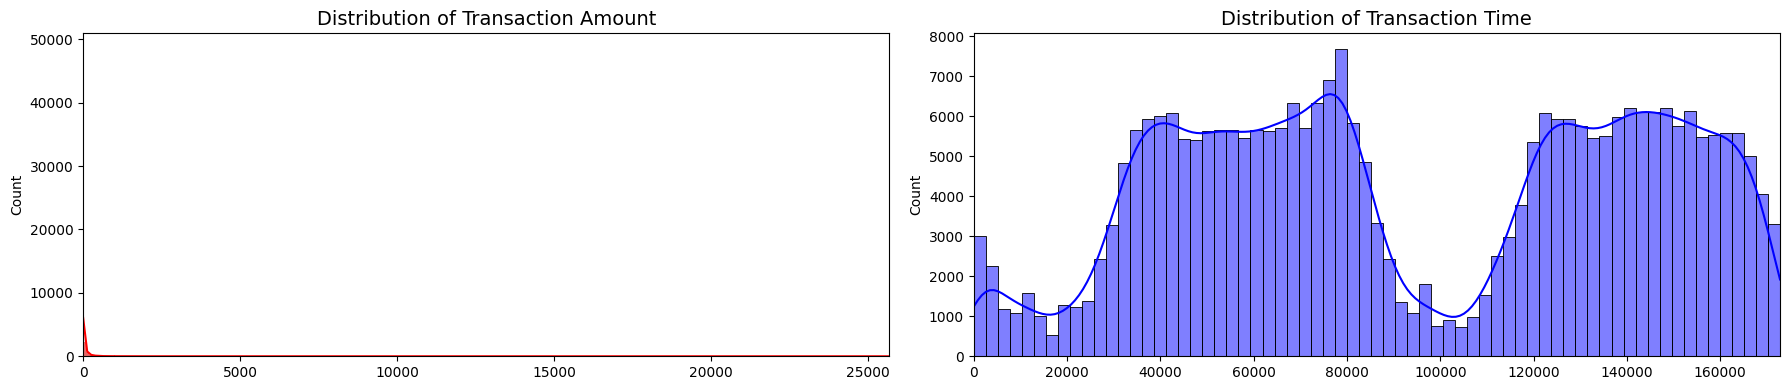

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Создание подграфиков
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

# Данные
amount_val = data['Amount'].values
time_val = data['Time'].values

sns.histplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

# График для распределения времени транзакций (Time)
sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

# Отображение графиков
plt.tight_layout()
plt.show()

In [74]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['Amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['Time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data[['Time', 'Amount']].head()

,Time,Amount
0,-0.995290,1.774718
1,-0.995290,-0.268530
2,-0.995279,4.959811
3,-0.995279,1.411487
4,-0.995267,0.667362


In [79]:
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold


X = data.drop(['Class'],axis=1)
y = data['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels

print(original_Xtest.shape)

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values


# # See if both the train and test label distribution are similarly distributed
# train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
# test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
# print('-' * 100)

# print('Label Distributions: \n')
# print(train_counts_label/ len(original_ytrain))
# print(test_counts_label/ len(original_ytest))

Train: [ 30191  30261  30275 ... 283723 283724 283725] Test: [    0     1     2 ... 56805 56806 56807]
Train: [     0      1      2 ... 283723 283724 283725] Test: [ 30191  30261  30275 ... 113535 113536 113537]
Train: [     0      1      2 ... 283723 283724 283725] Test: [ 77084  77379  79220 ... 170292 170293 170294]
Train: [     0      1      2 ... 283723 283724 283725] Test: [149302 150027 150068 ... 226999 227000 227001]
Train: [     0      1      2 ... 226999 227000 227001] Test: [212341 212365 213905 ... 283723 283724 283725]
(56745, 30)


In [ ]:
# from sklearn.metrics import f1_score, precision_score, recall_score

# predict = model.predict(X_test)
# print(f1_score(predict, y_test))
# print(precision_score(predict, y_test))
# print(recall_score(predict, y_test))